In [2]:
import pandas as pd
import numpy as np
from scipy.stats import sem
import matplotlib
from matplotlib.transforms import Affine2D
import matplotlib.pyplot as plt
import seaborn as sea
sea.set_style("white")
import os

def import_longform_results(e_file, filename):
    JS_scores = e_file['JS Distance Score'].tolist()
    kinase_targets =  e_file['kinase target'].tolist()
    inhibitor_names =  e_file['inhibitors'].tolist()
    test_types = ['p','n','i']
    test_indicator = filename.split('_')[6][0]
    test_number = (test_types.index(test_indicator))+1
    #print(filename, test_number)
    category = None
    alpha = None
    mu = None
    noise = None
    influence = None
    #prior test results
    if test_number == 1:
        #beta test
        if filename.split('_')[7][0] == 'b':
            alpha = float(filename.split('_')[-2])
            #print("alpha",alpha)
            category = 1
        #poisson test result
        else:
            mu = int(filename.split('.')[0].split('_')[-1])
            #print("mu",mu)
            category = 2
    #gaussian noise results
    if test_number == 2:
        category = 3
        noise = float(filename.split('.')[0].split('_')[-1])
        #print("noise", noise)
    #prior influence results
    if test_number == 3:
        category = 4
        influence = float(filename.split('_')[-1][:-5][:5])
        #print("inf", influence)
    return [category, alpha, mu, noise, influence, JS_scores, kinase_targets, inhibitor_names]

all_results = []

print(len(all_results))

for filename in os.listdir(os.getcwd()+'/param_scan_results/'):
    f = './param_scan_results/'+str(filename)
    for x in range(1,4):
        open_file = pd.read_excel(f, str(x))
        results = import_longform_results(open_file, filename)
        results.append(x)
        all_results.append(results)
        
print(len(all_results))

0
585


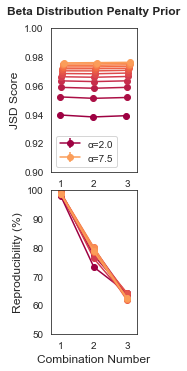

In [3]:
#Beta Distribution Prior Analysis

inhibitor_number = [1,2,3]
alpha_number = list(np.arange(2,8,0.5))
score_array = [[[] for x in range(0,len(inhibitor_number))] for x in range(0,len(alpha_number))]
score_array2 = [[[] for x in range(0,len(inhibitor_number))] for x in range(0,len(alpha_number))]
for res in all_results:
    if res[0] == 1:
        alpha = res[1]
        inhib_num = res[8]
        scores = res[5]
        kinase_targets = res[6]
        inhibitor_names = res[7]
        res_dict = {}
        for r in range(0, len(kinase_targets)):
            res_dict[kinase_targets[r]] = inhibitor_names[r]
        score_array[alpha_number.index(alpha)][inhibitor_number.index(inhib_num)].append(scores)
        score_array2[alpha_number.index(alpha)][inhibitor_number.index(inhib_num)].append(res_dict)
        
to_plot = []
for x in range(0,len(score_array)):
    i = []
    m = []
    _std = []
    _sem = []
    for y in range(0, len(score_array[x])):
        scores = score_array[x][y]
        stdev = np.std(scores)
        i.append(str(y+1))
        m.append(np.mean(scores))
        _std.append(np.std(scores))
        _sem.append(sem(scores, axis=None))
    to_plot.append([i, m, _std, _sem])
    
to_plot2 = []
for s in range(0,len(score_array2)):
    x_val = []
    y_val = []
    for y in range(0, len(score_array2[s])):
        max_value = 0
        all_targets = {}
        dict_set = score_array2[s][y]
        for individual_result in dict_set: #for every 1 of 5
            for kinase_target in individual_result: #for every kinase target
                if kinase_target not in all_targets: # if we haven't evaluated the kinase yet
                    result_list = [replicate[kinase_target] for replicate in dict_set]
                    #print(result_list)
                    unique_res = set(result_list)
                    #print(unique_res)
                    counts = [result_list.count(tmp) for tmp in unique_res]
                    all_targets[kinase_target] = max(counts)#in_agreement
        total = len(all_targets)*5
        correct = 0.0
        for k in all_targets:
            correct += all_targets[k]
        percent_correct = (correct/total)*100.0
        x_val.append(str(y+1))
        y_val.append(percent_correct)
    to_plot2.append([x_val, y_val])    
        
fig, ax = plt.subplots(2,1,figsize=(3,5))
c = 0
cmap = matplotlib.cm.get_cmap('Spectral')
for r in to_plot:
    alpha = alpha_number[c]
    rgba = cmap(c/(len(to_plot))*0.3)
    translation1 = Affine2D().translate(+((c*0.01)-0.02), 0.0) + ax[0].transData
    ax[0].errorbar(r[0], r[1], yerr = r[3], label='α='+str(alpha), color=rgba, marker="o", transform=translation1)
    c+=1
                    
c = 0
for entry in to_plot2:
    x_val = entry[0]
    y_val = entry[1]
    alpha = alpha_number[c]
    rgba = cmap(c/(len(to_plot))*0.3)
    translation = Affine2D().translate(+((c*0.01)-0.02), 0.0) + ax[1].transData
    ax[1].errorbar(x_val, y_val, label='α='+str(alpha), color=rgba, marker="o")
    c+=1   
    
lbls = ax[0].get_legend_handles_labels()
new_artists = [lbls[0][0],lbls[0][len(lbls[0])-1]]
new_lbls = [lbls[1][0],lbls[1][len(lbls[0])-1]]
ax[0].legend(new_artists,new_lbls)#,loc = 2, bbox_to_anchor = (1, 1.03))
ax[1].set_xlabel("Combination Number", size=12)
ax[0].set_ylabel("JSD Score", size=12)
ax[1].set_ylabel('Reproducibility (%)', size=12)
ax[0].set_ylim([0.9,1])
ax[1].set_ylim([50,100])
ax[0].set_xlim([-0.3,2.3])
ax[1].set_xlim([-0.3,2.3])
fig.suptitle("Beta Distribution Penalty Prior", size=12,weight="bold",x=0.3, y=1.01)
plt.tight_layout()
ax[0].set_position([0.1,0.55, 0.4, 0.4])
ax[1].set_position([0.1,0.1, 0.4, 0.4])
plt.show()

#fig.savefig("010821_beta_distribution_prior.pdf", bbox_inches='tight', dpi=1000)

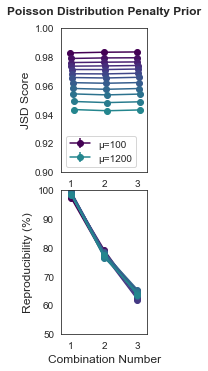

In [4]:
#Poisson Distribution Prior Analysis

inhibitor_number = [1,2,3]
mu_number = list(np.arange(100,1300,100))
score_array = [[[] for x in range(0,len(inhibitor_number))] for x in range(0,len(mu_number))]
score_array2 = [[[] for x in range(0,len(inhibitor_number))] for x in range(0,len(mu_number))]
for res in all_results:
    if res[0] == 2:
        mu = res[2]
        inhib_num = res[8]
        scores = res[5]
        kinase_targets = res[6]
        inhibitor_names = res[7]
        res_dict = {}
        for r in range(0, len(kinase_targets)):
            res_dict[kinase_targets[r]] = inhibitor_names[r]
        score_array[mu_number.index(mu)][inhibitor_number.index(inhib_num)].append(scores)
        score_array2[mu_number.index(mu)][inhibitor_number.index(inhib_num)].append(res_dict)
        
to_plot = []
for x in range(0,len(score_array)):
    i = []
    m = []
    _std = []
    _sem = []
    for y in range(0, len(score_array[x])):
        scores = score_array[x][y]
        stdev = np.std(scores)
        i.append(str(y+1))
        m.append(np.mean(scores))
        _std.append(np.std(scores))
        _sem.append(sem(scores, axis=None))
    to_plot.append([i, m, _std, _sem])
    
to_plot2 = []
for s in range(0,len(score_array2)):
    x_val = []
    y_val = []
    for y in range(0, len(score_array2[s])):
        max_value = 0
        all_targets = {}
        dict_set = score_array2[s][y]
        for individual_result in dict_set: #for every 1 of 5
            for kinase_target in individual_result: #for every kinase target
                if kinase_target not in all_targets: # if we haven't evaluated the kinase yet
                    result_list = [replicate[kinase_target] for replicate in dict_set]
                    #print(result_list)
                    unique_res = set(result_list)
                    #print(unique_res)
                    counts = [result_list.count(tmp) for tmp in unique_res]
                    all_targets[kinase_target] = max(counts)#in_agreement
        total = len(all_targets)*5
        correct = 0.0
        for k in all_targets:
            correct += all_targets[k]
        percent_correct = (correct/total)*100.0
        x_val.append(str(y+1))
        y_val.append(percent_correct)
    to_plot2.append([x_val, y_val])    
                            
fig, ax = plt.subplots(2,1,figsize=(3,5))
c = 0
cmap = matplotlib.cm.get_cmap('viridis')
for r in to_plot:
    alpha = mu_number[c]
    rgba = cmap(c/(len(to_plot))*0.5)
    translation1 = Affine2D().translate(+((c*0.01)-0.02), 0.0) + ax[0].transData
    ax[0].errorbar(r[0], r[1], yerr = r[3], label='μ='+str(alpha), color=rgba, marker="o", transform=translation1)
    c+=1
                    
c = 0
for entry in to_plot2:
    x_val = entry[0]
    y_val = entry[1]
    alpha = mu_number[c]
    rgba = cmap(c/(len(to_plot))*0.5)
    translation = Affine2D().translate(+((c*0.01)-0.02), 0.0) + ax[1].transData
    ax[1].errorbar(x_val, y_val, label='μ='+str(alpha), color=rgba, marker="o")
    c+=1                  
                                        
lbls = ax[0].get_legend_handles_labels()
new_artists = [lbls[0][0],lbls[0][len(lbls[0])-1]]
new_lbls = [lbls[1][0],lbls[1][len(lbls[0])-1]]
ax[0].legend(new_artists,new_lbls)#,loc = 2, bbox_to_anchor = (1, 1.03))
ax[1].set_xlabel("Combination Number", size=12)
ax[0].set_ylabel("JSD Score", size=12)
ax[1].set_ylabel('Reproducibility (%)', size=12)
ax[0].set_ylim([0.9,1])
ax[1].set_ylim([50,100])
ax[0].set_xlim([-0.3,2.3])
ax[1].set_xlim([-0.3,2.3])
fig.suptitle("Poisson Distribution Penalty Prior", size=12,weight="bold",x=0.3, y=1.01)
plt.tight_layout()
ax[0].set_position([0.1,0.55, 0.4, 0.4])
ax[1].set_position([0.1,0.1, 0.4, 0.4])
plt.show()

#fig.savefig("010821_poisson_distribution_prior.pdf", bbox_inches='tight', dpi=1000)

['1', '2', '3'] [0.969264810313399, 0.9688088399863333, 0.9693067883295018]
['1', '2', '3'] [0.9670072437536286, 0.9667622709148114, 0.9671016387576066]
['1', '2', '3'] [0.9657450342214731, 0.9654211775172157, 0.9658898992073429]
['1', '2', '3'] [0.9646166475677815, 0.964347678389433, 0.9648407012461442]
['1', '2', '3'] [0.963595959582246, 0.9633708136567914, 0.9639077231704193]
['1', '2', '3'] [0.9630224997867606, 0.9627581761391041, 0.9632894673000935]


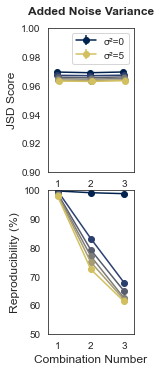

In [5]:
#as a function of the noise variance

inhibitor_number = [1,2,3]
n_number = list(np.arange(0,6,1))
score_array = [[[] for x in range(0,len(inhibitor_number))] for x in range(0,len(n_number))]
score_array2 = [[[] for x in range(0,len(inhibitor_number))] for x in range(0,len(n_number))]
for res in all_results:
    if res[0] == 3:
        noise = res[3]
        inhib_num = res[8]
        scores = res[5]
        kinase_targets = res[6]
        inhibitor_names = res[7]
        res_dict = {}
        for r in range(0, len(kinase_targets)):
            res_dict[kinase_targets[r]] = inhibitor_names[r]
        score_array[n_number.index(noise)][inhibitor_number.index(inhib_num)].append(scores)
        score_array2[n_number.index(noise)][inhibitor_number.index(inhib_num)].append(res_dict)
        
to_plot = []
for x in range(0,len(score_array)):
    i = []
    m = []
    _std = []
    _sem = []
    for y in range(0, len(score_array[x])):
        scores = score_array[x][y]
        stdev = np.std(scores)
        i.append(str(y+1))
        m.append(np.mean(scores))
        _std.append(np.std(scores))
        _sem.append(sem(scores, axis=None))
    to_plot.append([i, m, _std, _sem])
    
to_plot2 = []
for s in range(0,len(score_array2)):
    x_val = []
    y_val = []
    for y in range(0, len(score_array2[s])):
        max_value = 0
        all_targets = {}
        dict_set = score_array2[s][y]
        for individual_result in dict_set: #for every 1 of 5
            for kinase_target in individual_result: #for every kinase target
                if kinase_target not in all_targets: # if we haven't evaluated the kinase yet
                    result_list = [replicate[kinase_target] for replicate in dict_set]
                    #print(result_list)
                    unique_res = set(result_list)
                    #print(unique_res)
                    counts = [result_list.count(tmp) for tmp in unique_res]
                    all_targets[kinase_target] = max(counts)#in_agreement
        total = len(all_targets)*5
        correct = 0.0
        for k in all_targets:
            correct += all_targets[k]
        percent_correct = (correct/total)*100.0
        x_val.append(str(y+1))
        y_val.append(percent_correct)
    to_plot2.append([x_val, y_val])    
        
fig, ax = plt.subplots(2,1,figsize=(3,5))
c = 0
cmap = matplotlib.cm.get_cmap('cividis')
for r in to_plot:
    alpha = n_number[c]
    rgba = cmap(c/(len(to_plot)))
    translation1 = Affine2D().translate(+((c*0.01)-0.02), 0.0) + ax[0].transData
    ax[0].errorbar(r[0], r[1], yerr = r[3], label='σ²='+str(alpha), color=rgba, marker="o", transform=translation1)
    c+=1
    print(r[0],r[1])
                    
c = 0
for entry in to_plot2:
    x_val = entry[0]
    y_val = entry[1]
    alpha = n_number[c]
    rgba = cmap(c/(len(to_plot)))
    translation = Affine2D().translate(+((c*0.01)-0.02), 0.0) + ax[1].transData
    ax[1].errorbar(x_val, y_val, label='σ²='+str(alpha), color=rgba, marker="o")
    c+=1                  
                                        
lbls = ax[0].get_legend_handles_labels()
new_artists = [lbls[0][0],lbls[0][len(lbls[0])-1]]
new_lbls = [lbls[1][0],lbls[1][len(lbls[0])-1]]
ax[0].legend(new_artists,new_lbls)#,loc = 2, bbox_to_anchor = (1, 1.03))
ax[1].set_xlabel("Combination Number", size=12)
ax[0].set_ylabel("JSD Score", size=12)
ax[1].set_ylabel('Reproducibility (%)', size=12)
ax[0].set_ylim([0.9,1])
ax[1].set_ylim([50,100])
ax[0].set_xlim([-0.3,2.3])
ax[1].set_xlim([-0.3,2.3])
fig.suptitle("Added Noise Variance", size=12,weight="bold",x=0.3, y=1.01)
plt.tight_layout()
ax[0].set_position([0.1,0.55, 0.4, 0.4])
ax[1].set_position([0.1,0.1, 0.4, 0.4])
plt.show()

fig.savefig("012621_normal_noise_variance_ylim_change.pdf", bbox_inches='tight',dpi=1000)

['1', '2', '3'] [0.969264810313399, 0.9688088399863333, 0.9693067883295018]
['1', '2', '3'] [0.9670072437536286, 0.9667622709148114, 0.9671016387576066]
['1', '2', '3'] [0.9657450342214731, 0.9654211775172157, 0.9658898992073429]
['1', '2', '3'] [0.9646166475677815, 0.964347678389433, 0.9648407012461442]
['1', '2', '3'] [0.963595959582246, 0.9633708136567914, 0.9639077231704193]
['1', '2', '3'] [0.9630224997867606, 0.9627581761391041, 0.9632894673000935]


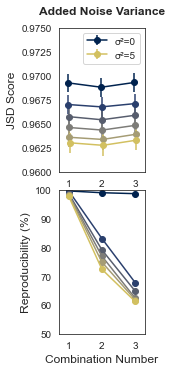

In [6]:
#as a function of the noise variance

inhibitor_number = [1,2,3]
n_number = list(np.arange(0,6,1))
score_array = [[[] for x in range(0,len(inhibitor_number))] for x in range(0,len(n_number))]
score_array2 = [[[] for x in range(0,len(inhibitor_number))] for x in range(0,len(n_number))]
for res in all_results:
    if res[0] == 3:
        noise = res[3]
        inhib_num = res[8]
        scores = res[5]
        kinase_targets = res[6]
        inhibitor_names = res[7]
        res_dict = {}
        for r in range(0, len(kinase_targets)):
            res_dict[kinase_targets[r]] = inhibitor_names[r]
        score_array[n_number.index(noise)][inhibitor_number.index(inhib_num)].append(scores)
        score_array2[n_number.index(noise)][inhibitor_number.index(inhib_num)].append(res_dict)
        
to_plot = []
for x in range(0,len(score_array)):
    i = []
    m = []
    _std = []
    _sem = []
    for y in range(0, len(score_array[x])):
        scores = score_array[x][y]
        stdev = np.std(scores)
        i.append(str(y+1))
        m.append(np.mean(scores))
        _std.append(np.std(scores))
        _sem.append(sem(scores, axis=None))
    to_plot.append([i, m, _std, _sem])
    
to_plot2 = []
for s in range(0,len(score_array2)):
    x_val = []
    y_val = []
    for y in range(0, len(score_array2[s])):
        max_value = 0
        all_targets = {}
        dict_set = score_array2[s][y]
        for individual_result in dict_set: #for every 1 of 5
            for kinase_target in individual_result: #for every kinase target
                if kinase_target not in all_targets: # if we haven't evaluated the kinase yet
                    result_list = [replicate[kinase_target] for replicate in dict_set]
                    #print(result_list)
                    unique_res = set(result_list)
                    #print(unique_res)
                    counts = [result_list.count(tmp) for tmp in unique_res]
                    all_targets[kinase_target] = max(counts)#in_agreement
        total = len(all_targets)*5
        correct = 0.0
        for k in all_targets:
            correct += all_targets[k]
        percent_correct = (correct/total)*100.0
        x_val.append(str(y+1))
        y_val.append(percent_correct)
    to_plot2.append([x_val, y_val])    
        
fig, ax = plt.subplots(2,1,figsize=(3,5))
c = 0
cmap = matplotlib.cm.get_cmap('cividis')
for r in to_plot:
    alpha = n_number[c]
    rgba = cmap(c/(len(to_plot)))
    translation1 = Affine2D().translate(+((c*0.01)-0.02), 0.0) + ax[0].transData
    ax[0].errorbar(r[0], r[1], yerr = r[3], label='σ²='+str(alpha), color=rgba, marker="o", transform=translation1)
    c+=1
    print(r[0],r[1])
                    
c = 0
for entry in to_plot2:
    x_val = entry[0]
    y_val = entry[1]
    alpha = n_number[c]
    rgba = cmap(c/(len(to_plot)))
    translation = Affine2D().translate(+((c*0.01)-0.02), 0.0) + ax[1].transData
    ax[1].errorbar(x_val, y_val, label='σ²='+str(alpha), color=rgba, marker="o")
    c+=1                  
                                        
lbls = ax[0].get_legend_handles_labels()
new_artists = [lbls[0][0],lbls[0][len(lbls[0])-1]]
new_lbls = [lbls[1][0],lbls[1][len(lbls[0])-1]]
ax[0].legend(new_artists,new_lbls)#,loc = 2, bbox_to_anchor = (1, 1.03))
ax[1].set_xlabel("Combination Number", size=12)
ax[0].set_ylabel("JSD Score", size=12)
ax[1].set_ylabel('Reproducibility (%)', size=12)
ax[0].set_ylim([0.96,0.975])
ax[1].set_ylim([50,100])
ax[0].set_xlim([-0.3,2.3])
ax[1].set_xlim([-0.3,2.3])
fig.suptitle("Added Noise Variance", size=12,weight="bold",x=0.3, y=1.01)
plt.tight_layout()
ax[0].set_position([0.1,0.55, 0.4, 0.4])
ax[1].set_position([0.1,0.1, 0.4, 0.4])
plt.show()

#fig.savefig("010821_normal_noise_variance.pdf", bbox_inches='tight',dpi=1000)

['1', '2', '3'] [0.9644894885405638, 0.9641975883480357, 0.9646085730752028]
['1', '2', '3'] [0.9648630919661443, 0.9645206717402959, 0.9649578454984723]
['1', '2', '3'] [0.9650289540472303, 0.9647652618164259, 0.9652201095103038]
['1', '2', '3'] [0.9652880234941678, 0.9650231638921585, 0.9654885361424465]
['1', '2', '3'] [0.9653225203707179, 0.9650678213834794, 0.9655636533119936]
['1', '2', '3'] [0.9654885797913654, 0.9651743984505836, 0.9656650478736272]
['1', '2', '3'] [0.9656510703996513, 0.9653506454325939, 0.9658684292007597]
['1', '2', '3'] [0.9658103526848326, 0.9655617990750139, 0.9660603120431287]
['1', '2', '3'] [0.9659923853459755, 0.965704371927494, 0.9662281373545324]


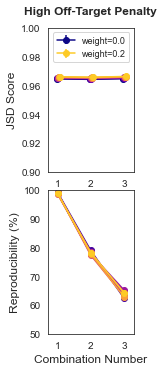

In [10]:
#make two figures of the change in JS score over i=1->3, one for the SEM and on for the STD of the data
#as a function of the on-target weight

inhibitor_number = [1,2,3]
n_number = [0.0,0.025,0.05,0.075,0.1,0.125,0.15,0.175,0.2]
score_array = [[[] for x in range(0,len(inhibitor_number))] for x in range(0,len(n_number))]
score_array2 = [[[] for x in range(0,len(inhibitor_number))] for x in range(0,len(n_number))]
for res in all_results:
    if res[0] == 4:
        inf = res[4]
        inhib_num = res[8]
        scores = res[5]
        kinase_targets = res[6]
        inhibitor_names = res[7]
        res_dict = {}
        for r in range(0, len(kinase_targets)):
            res_dict[kinase_targets[r]] = inhibitor_names[r]
        score_array[n_number.index(inf)][inhibitor_number.index(inhib_num)].append(scores)
        score_array2[n_number.index(inf)][inhibitor_number.index(inhib_num)].append(res_dict)
        
to_plot = []
for x in range(0,len(score_array)):
    i = []
    m = []
    _std = []
    _sem = []
    for y in range(0, len(score_array[x])):
        scores = score_array[x][y]
        stdev = np.std(scores)
        i.append(str(y+1))
        m.append(np.mean(scores))
        _std.append(np.std(scores))
        _sem.append(sem(scores, axis=None))
    to_plot.append([i, m, _std, _sem])
    
to_plot2 = []
for s in range(0,len(score_array2)):
    x_val = []
    y_val = []
    for y in range(0, len(score_array2[s])):
        max_value = 0
        all_targets = {}
        dict_set = score_array2[s][y]
        for individual_result in dict_set: #for every 1 of 5
            for kinase_target in individual_result: #for every kinase target
                if kinase_target not in all_targets: # if we haven't evaluated the kinase yet
                    result_list = [replicate[kinase_target] for replicate in dict_set]
                    #print(result_list)
                    unique_res = set(result_list)
                    #print(unique_res)
                    counts = [result_list.count(tmp) for tmp in unique_res]
                    all_targets[kinase_target] = max(counts)#in_agreement
        total = len(all_targets)*5
        correct = 0.0
        for k in all_targets:
            correct += all_targets[k]
        percent_correct = (correct/total)*100.0
        x_val.append(str(y+1))
        y_val.append(percent_correct)
    to_plot2.append([x_val, y_val])    
        
fig, ax = plt.subplots(2,1,figsize=(3,5))
c = 0
cmap = matplotlib.cm.get_cmap('plasma')
for r in to_plot:
    inf = n_number[c]
    rgba = cmap(c/len(to_plot))
    #translation1 = Affine2D().translate(+((c*0.01)-0.02), 0.0) + ax[0].transData
    translation2 = Affine2D().translate(+((c*0.01)-0.02), 0.0) + ax[0].transData
    #ax[0].errorbar(r[0], r[1], yerr = r[2], label='weight='+str(inf), color=rgba, marker="o", transform=translation1)
    ax[0].errorbar(r[0], r[1], yerr = r[3], label='weight='+str(inf), color=rgba, marker="o", transform=translation2)
    c+=1
    print(r[0],r[1])
                    
c = 0
for entry in to_plot2:
    x_val = entry[0]
    y_val = entry[1]
    inf = n_number[c]
    rgba = cmap(c/len(to_plot))
    translation = Affine2D().translate(+((c*0.01)-0.02), 0.0) + ax[1].transData
    ax[1].errorbar(x_val, y_val, label='weight='+str(inf), color=rgba, marker="o")
    c+=1                  
                                        
lbls = ax[0].get_legend_handles_labels()
new_artists = [lbls[0][0],lbls[0][len(lbls[0])-1]]
new_lbls = [lbls[1][0],lbls[1][len(lbls[0])-1]]
ax[0].legend(new_artists,new_lbls,prop={'size': 9})#,loc = 2, bbox_to_anchor = (1, 1.03))
ax[1].set_xlabel("Combination Number", size=12)
ax[0].set_ylabel("JSD Score", size=12)
ax[1].set_ylabel('Reproducibility (%)', size=12)
ax[0].set_ylim([0.9,1])
ax[1].set_ylim([50,100])
ax[0].set_xlim([-0.3,2.3])
ax[1].set_xlim([-0.3,2.3])
fig.suptitle("High Off-Target Penalty", size=12,weight="bold",x=0.3, y=1.01)
plt.tight_layout()
ax[0].set_position([0.1,0.55, 0.4, 0.4])
ax[1].set_position([0.1,0.1, 0.4, 0.4])
plt.show()

fig.savefig("010821_high-off-target-penalty-ylim-change.pdf",bbox_inches='tight',dpi=1000)

['1', '2', '3'] [0.9644894885405638, 0.9641975883480357, 0.9646085730752028]
['1', '2', '3'] [0.9648630919661443, 0.9645206717402959, 0.9649578454984723]
['1', '2', '3'] [0.9650289540472303, 0.9647652618164259, 0.9652201095103038]
['1', '2', '3'] [0.9652880234941678, 0.9650231638921585, 0.9654885361424465]
['1', '2', '3'] [0.9653225203707179, 0.9650678213834794, 0.9655636533119936]
['1', '2', '3'] [0.9654885797913654, 0.9651743984505836, 0.9656650478736272]
['1', '2', '3'] [0.9656510703996513, 0.9653506454325939, 0.9658684292007597]
['1', '2', '3'] [0.9658103526848326, 0.9655617990750139, 0.9660603120431287]
['1', '2', '3'] [0.9659923853459755, 0.965704371927494, 0.9662281373545324]


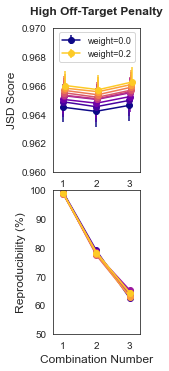

In [11]:
#make two figures of the change in JS score over i=1->3, one for the SEM and on for the STD of the data
#as a function of the on-target weight

inhibitor_number = [1,2,3]
n_number = [0.0,0.025,0.05,0.075,0.1,0.125,0.15,0.175,0.2]
score_array = [[[] for x in range(0,len(inhibitor_number))] for x in range(0,len(n_number))]
score_array2 = [[[] for x in range(0,len(inhibitor_number))] for x in range(0,len(n_number))]
for res in all_results:
    if res[0] == 4:
        inf = res[4]
        inhib_num = res[8]
        scores = res[5]
        kinase_targets = res[6]
        inhibitor_names = res[7]
        res_dict = {}
        for r in range(0, len(kinase_targets)):
            res_dict[kinase_targets[r]] = inhibitor_names[r]
        score_array[n_number.index(inf)][inhibitor_number.index(inhib_num)].append(scores)
        score_array2[n_number.index(inf)][inhibitor_number.index(inhib_num)].append(res_dict)
        
to_plot = []
for x in range(0,len(score_array)):
    i = []
    m = []
    _std = []
    _sem = []
    for y in range(0, len(score_array[x])):
        scores = score_array[x][y]
        stdev = np.std(scores)
        i.append(str(y+1))
        m.append(np.mean(scores))
        _std.append(np.std(scores))
        _sem.append(sem(scores, axis=None))
    to_plot.append([i, m, _std, _sem])
    
to_plot2 = []
for s in range(0,len(score_array2)):
    x_val = []
    y_val = []
    for y in range(0, len(score_array2[s])):
        max_value = 0
        all_targets = {}
        dict_set = score_array2[s][y]
        for individual_result in dict_set: #for every 1 of 5
            for kinase_target in individual_result: #for every kinase target
                if kinase_target not in all_targets: # if we haven't evaluated the kinase yet
                    result_list = [replicate[kinase_target] for replicate in dict_set]
                    #print(result_list)
                    unique_res = set(result_list)
                    #print(unique_res)
                    counts = [result_list.count(tmp) for tmp in unique_res]
                    all_targets[kinase_target] = max(counts)#in_agreement
        total = len(all_targets)*5
        correct = 0.0
        for k in all_targets:
            correct += all_targets[k]
        percent_correct = (correct/total)*100.0
        x_val.append(str(y+1))
        y_val.append(percent_correct)
    to_plot2.append([x_val, y_val])    
        
fig, ax = plt.subplots(2,1,figsize=(3,5))
c = 0
cmap = matplotlib.cm.get_cmap('plasma')
for r in to_plot:
    inf = n_number[c]
    rgba = cmap(c/len(to_plot))
    #translation1 = Affine2D().translate(+((c*0.01)-0.02), 0.0) + ax[0].transData
    translation2 = Affine2D().translate(+((c*0.01)-0.02), 0.0) + ax[0].transData
    #ax[0].errorbar(r[0], r[1], yerr = r[2], label='weight='+str(inf), color=rgba, marker="o", transform=translation1)
    ax[0].errorbar(r[0], r[1], yerr = r[3], label='weight='+str(inf), color=rgba, marker="o", transform=translation2)
    c+=1
    print(r[0],r[1])
                    
c = 0
for entry in to_plot2:
    x_val = entry[0]
    y_val = entry[1]
    inf = n_number[c]
    rgba = cmap(c/len(to_plot))
    translation = Affine2D().translate(+((c*0.01)-0.02), 0.0) + ax[1].transData
    ax[1].errorbar(x_val, y_val, label='weight='+str(inf), color=rgba, marker="o")
    c+=1                  
                                        
lbls = ax[0].get_legend_handles_labels()
new_artists = [lbls[0][0],lbls[0][len(lbls[0])-1]]
new_lbls = [lbls[1][0],lbls[1][len(lbls[0])-1]]
ax[0].legend(new_artists,new_lbls,prop={'size': 9})#,loc = 2, bbox_to_anchor = (1, 1.03))
ax[1].set_xlabel("Combination Number", size=12)
ax[0].set_ylabel("JSD Score", size=12)
ax[1].set_ylabel('Reproducibility (%)', size=12)
ax[0].set_ylim([0.96,0.97])
ax[1].set_ylim([50,100])
ax[0].set_xlim([-0.3,2.3])
ax[1].set_xlim([-0.3,2.3])
fig.suptitle("High Off-Target Penalty", size=12,weight="bold",x=0.3, y=1.01)
plt.tight_layout()
ax[0].set_position([0.1,0.55, 0.4, 0.4])
ax[1].set_position([0.1,0.1, 0.4, 0.4])
plt.show()

fig.savefig("010821_high-off-target-penalty.pdf",bbox_inches='tight',dpi=1000)

In [12]:
#Now, generate a figure that compares the JS scores against the reproducibility of the data, in order to compare the two different types of priors
from sklearn.metrics import r2_score

longform_results = []
    
for filename in os.listdir(os.getcwd()+'/param_scan_results/'):
    f = './param_scan_results/'+str(filename)
    for x in range(1,4):
        open_file = pd.read_excel(f, str(x))
        results = import_longform_results(open_file, filename)
        results.append(x)
        longform_results.append(results)

inhibitor_number = [1,2,3]
alpha_number = list(np.arange(2,8,0.5))
poisson_number = list(np.arange(100,1300,100))

#tests #1-4...
test_results = [[], []]
for result in longform_results:
    if result[0] == 1 or result[0] == 2:
        test_results[result[0]-1].append(result)
to_plot = []
for x in range(0,2):
    test_result = test_results[x]
    score_array = None
    if x == 0:
        score_array = [[[] for x in range(0,len(inhibitor_number))] for x in range(0,len(alpha_number))]
    elif x == 1:
        score_array = [[[] for x in range(0,len(inhibitor_number))] for x in range(0,len(poisson_number))]
    for res in test_result:
        JS_scores = res[5]
        inhib_num = res[8]
        kinase_targets = res[6]
        inhibitor_names = res[7]
        res_dict = {}
        for r in range(0, len(kinase_targets)):
            res_dict[kinase_targets[r]] = inhibitor_names[r]
        if x == 0:
            alpha = res[1]
            score_array[alpha_number.index(alpha)][inhibitor_number.index(inhib_num)].append((res_dict, JS_scores))
        if x == 1:
            mu = res[2]
            score_array[poisson_number.index(mu)][inhibitor_number.index(inhib_num)].append((res_dict, JS_scores))
    from_test = [] 
    for s in range(0,len(score_array)):
        x_val = []
        y_val = []
        x_error_val = []
        for y in range(0, len(score_array[s])):
            max_value = 0
            all_targets = {}
            all_scores = []
            dict_set = []
            for tech_replicate in score_array[s][y]:
                all_scores = all_scores + tech_replicate[1]
                dict_set.append(tech_replicate[0])
            mean_score = np.mean(all_scores)
            sem_scores = sem(all_scores, axis=None)
            for individual_result in dict_set: #for every 1 of 5
                for kinase_target in individual_result: #for every kinase target
                    if kinase_target not in all_targets: # if we haven't evaluated the kinase yet
                        result_list = [replicate[kinase_target] for replicate in dict_set]
                        #print(result_list)
                        unique_res = set(result_list)
                        #print(unique_res)
                        counts = [result_list.count(tmp) for tmp in unique_res]
                        all_targets[kinase_target] = max(counts)#in_agreement
            total = len(all_targets)*5
            correct = 0.0
            for k in all_targets:
                correct += all_targets[k]
            percent_correct = (correct/total)*100.0
            y_val.append(percent_correct)
            x_val.append(mean_score)
            x_error_val.append(sem_scores)
        from_test.append([x_val, y_val, x_error_val])
    to_plot.append(from_test)

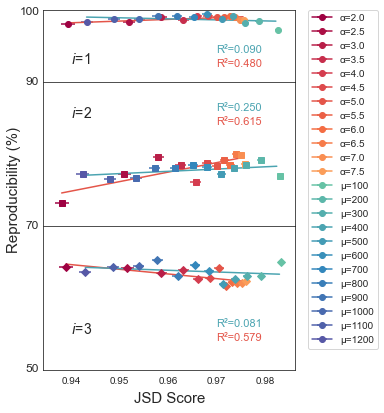

In [13]:
from sklearn.metrics import r2_score

i1_beta_vals = [[],[]]
i1_poi_vals = [[],[]]
i2_beta_vals = [[],[]]
i2_poi_vals = [[],[]]
i3_beta_vals = [[],[]]
i3_poi_vals = [[],[]]
        
cmap = matplotlib.cm.get_cmap('Spectral')
fig, ax = plt.subplots(3, sharex=True, figsize=(5,5))
test_name = ''
for i in range(0, len(to_plot)):
    for j in range(0, len(to_plot[i])):
        x_val = to_plot[i][j][0]
        x_error = to_plot[i][j][2]
        y_val = to_plot[i][j][1]
        if i==0:
            alpha = alpha_number[j]
            rgba = cmap((j/len(to_plot[i]))*0.3)
            for l in range(0,3):
                if l == 0:
                    ax[0].errorbar(x_val[l], y_val[l], xerr = x_error[l], label='α='+str(alpha), color=rgba, marker='o')
                    i1_beta_vals[0].append(x_val[l])
                    i1_beta_vals[1].append(y_val[l])
                if l == 1:
                    ax[1].errorbar(x_val[l], y_val[l], xerr = x_error[l], color=rgba, marker='s')
                    i2_beta_vals[0].append(x_val[l])
                    i2_beta_vals[1].append(y_val[l])
                if l == 2:
                    ax[2].errorbar(x_val[l], y_val[l], xerr = x_error[l], color=rgba, marker='D')
                    i3_beta_vals[0].append(x_val[l])
                    i3_beta_vals[1].append(y_val[l])
        if i==1:
            mu = poisson_number[j]
            rgba = cmap(((j/len(to_plot[i]))*0.2)+0.8)
            for l in range(0, 3):
                if l == 0:
                    ax[0].errorbar(x_val[l], y_val[l], xerr = x_error[l], label='μ='+str(mu), color=rgba, marker='o')
                    i1_poi_vals[0].append(x_val[l])
                    i1_poi_vals[1].append(y_val[l])
                if l == 1:
                    ax[1].errorbar(x_val[l], y_val[l], xerr = x_error[l], color=rgba, marker='s')
                    i2_poi_vals[0].append(x_val[l])
                    i2_poi_vals[1].append(y_val[l])
                if l == 2:
                    ax[2].errorbar(x_val[l], y_val[l], xerr = x_error[l], color=rgba, marker='D')
                    i3_poi_vals[0].append(x_val[l])
                    i3_poi_vals[1].append(y_val[l])
#ax[2].set_xlabel("JSD Score", size=15)
#ax[1].set_ylabel("Reproducibility (%)", size=12)
ax[0].grid(False)
ax[1].grid(False)
ax[2].grid(False)
ax[0].set_ylim([90,100])
ax[1].set_ylim([70,90])
ax[2].set_ylim([50,70])

beta_i1_linear_model=np.polyfit(i1_beta_vals[0],i1_beta_vals[1],1) #make the models
beta_i2_linear_model=np.polyfit(i2_beta_vals[0],i2_beta_vals[1],1)
beta_i3_linear_model=np.polyfit(i3_beta_vals[0],i3_beta_vals[1],1)
poi_i1_linear_model=np.polyfit(i1_poi_vals[0],i1_poi_vals[1],1)
poi_i2_linear_model=np.polyfit(i2_poi_vals[0],i2_poi_vals[1],1)
poi_i3_linear_model=np.polyfit(i3_poi_vals[0],i3_poi_vals[1],1)

beta_i1_linear_model_fn=np.poly1d(beta_i1_linear_model) #define a prediction from the model
beta_i1_R2 = r2_score(i1_beta_vals[1], beta_i1_linear_model_fn(i1_beta_vals[0])) #compute R2 from actual and predictions
x_vals = np.arange(np.min(i1_beta_vals[0]), np.max(i1_beta_vals[0]), 0.001)
ax[0].plot(x_vals,beta_i1_linear_model_fn(x_vals),color=cmap(0.15))
ax[0].text(0.97,((100-90)*0.2)+90,'R²='+str(beta_i1_R2)[:5], fontsize=11, color=cmap(0.15))

poi_i1_linear_model_fn=np.poly1d(poi_i1_linear_model)
poi_i1_R2 = r2_score(i1_poi_vals[1], poi_i1_linear_model_fn(i1_poi_vals[0]))
x_vals = np.arange(np.min(i1_poi_vals[0]), np.max(i1_poi_vals[0]), 0.001)
ax[0].plot(x_vals,poi_i1_linear_model_fn(x_vals),color=cmap(0.85))
ax[0].text(0.97,((100-90)*0.4)+90,'R²='+str(poi_i1_R2)[:5], fontsize=11, color=cmap(0.85))

beta_i2_linear_model_fn=np.poly1d(beta_i2_linear_model)
beta_i2_R2 = r2_score(i2_beta_vals[1], beta_i2_linear_model_fn(i2_beta_vals[0]))
x_vals = np.arange(np.min(i2_beta_vals[0]), np.max(i2_beta_vals[0]), 0.001)
ax[1].plot(x_vals,beta_i2_linear_model_fn(x_vals),color=cmap(0.15))
ax[1].text(0.97,((90-70)*0.7)+70,'R²='+str(beta_i2_R2)[:5], fontsize=11, color=cmap(0.15))

poi_i2_linear_model_fn=np.poly1d(poi_i2_linear_model)
poi_i2_R2 = r2_score(i2_poi_vals[1], poi_i2_linear_model_fn(i2_poi_vals[0]))
x_vals = np.arange(np.min(i2_poi_vals[0]), np.max(i2_poi_vals[0]), 0.001)
ax[1].plot(x_vals,poi_i2_linear_model_fn(x_vals),color=cmap(0.85))
ax[1].text(0.97,((90-70)*0.8)+70,'R²='+str(poi_i2_R2)[:5], fontsize=11, color=cmap(0.85))

beta_i3_linear_model_fn=np.poly1d(beta_i3_linear_model)
beta_i3_R2 = r2_score(i3_beta_vals[1], beta_i3_linear_model_fn(i3_beta_vals[0]))
x_vals = np.arange(np.min(i3_beta_vals[0]), np.max(i3_beta_vals[0]), 0.001)
ax[2].plot(x_vals,beta_i3_linear_model_fn(x_vals),color=cmap(0.15))
ax[2].text(0.97,((70-50)*0.2)+50,'R²='+str(beta_i3_R2)[:5], fontsize=11, color=cmap(0.15))

poi_i3_linear_model_fn=np.poly1d(poi_i3_linear_model)
poi_i3_R2 = r2_score(i3_poi_vals[1], poi_i3_linear_model_fn(i3_poi_vals[0]))
x_vals = np.arange(np.min(i3_poi_vals[0]), np.max(i3_poi_vals[0]), 0.001)
ax[2].plot(x_vals,poi_i3_linear_model_fn(x_vals),color=cmap(0.85))
ax[2].text(0.97,((70-50)*0.3)+50,'R²='+str(poi_i3_R2)[:5], fontsize=11, color=cmap(0.85))

ax[0].text(0.94,92.5,'$\it{i}$=1', fontsize=14)
ax[1].text(0.94,85,'$\it{i}$=2', fontsize=14)
ax[2].text(0.94,55,'$\it{i}$=3', fontsize=14)

ax[0].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

ax[0].set_position([0,0.8, 0.7, 0.2])
ax[1].set_position([0,0.4, 0.7, 0.4])
ax[2].set_position([0,0, 0.7, 0.4])

ax[0].set_yticklabels([])
ax[1].set_yticklabels([])
ax[2].set_yticklabels([])

fig.text(-0.065,0.985,"100", fontsize=12)
fig.text(-0.05,0.79,"90", fontsize=12)
fig.text(-0.05,0.39,"70", fontsize=12)
fig.text(-0.05,-0.005,"50", fontsize=12)

fig.supylabel("Reproducibility (%)",x=-0.1,fontsize=15)
fig.supxlabel("JSD Score",x=0.35,y=-0.1,fontsize=15)

plt.show()

fig.savefig("010821_prior_distributions_comparison.pdf", bbox_inches='tight', dpi=1000)